In [1]:
import pandas as pd
from data_split import split_csv
import matplotlib.pyplot as plt
from visualization import plot_class_distribution, plot_feature_importance,plot_predicted_vs_actual,get_land_cover_labels_and_colors, plot_and_save_land_cover_metrics, plot_scatter_per_land_cover_with_metrics, plot_density_scatter_per_land_cover
from accuracy_matrix import regression_metrics, compute_metrics
from randomforest_config import train_random_forest, train_random_forest_randomized_train_val,cross_validate_rf, train_rf_final
import os


# Split data into training (40%), validation (30%), testing (30%)

In [2]:
# Plit data as training (40%) test (30%) validation (30%)
split_csv(
    input_path=r"/home/varunt/Downloads/Data/Data_MODIS_hillshade_output_2021_without_11_15_17.csv",
    #output_dir=r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water",n_samples=320000
    output_dir=r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water"
)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

# Plot Class distribution

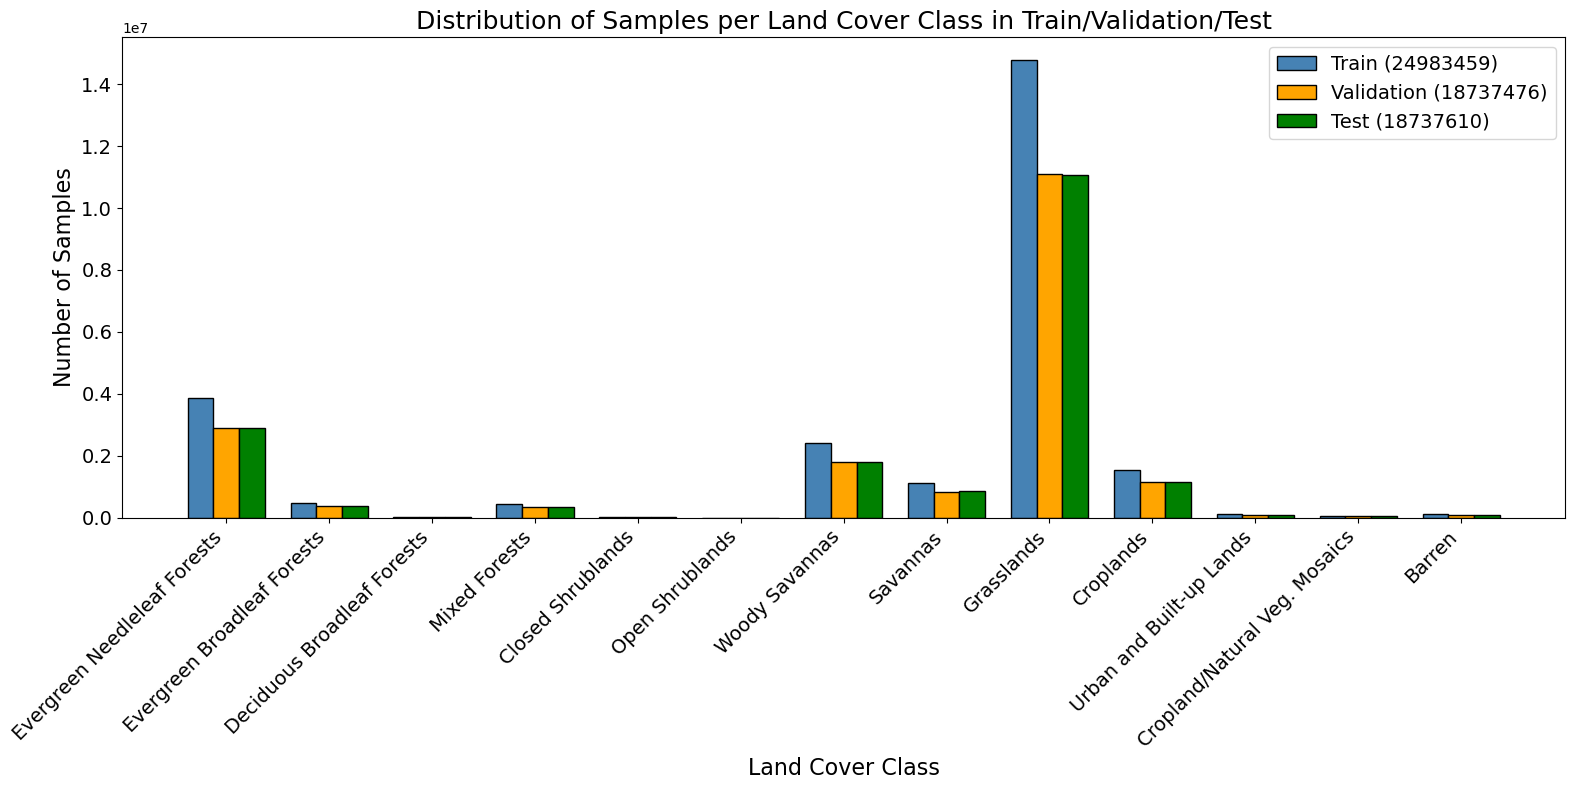

In [7]:
# plot distribution of train/test/validate per land cover
plot_class_distribution(
    train_path=r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/train.csv",
    val_path=r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/validation.csv",
    test_path=r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/test.csv",
    class_column="landcover"  # change if your column is named differently
)

# Data preprocess for RF

In [76]:
# read training data
train=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/train.csv")
test=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/test.csv")
validation=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/validation.csv")
output_dir = r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/hyperparameter"
train=train.dropna()
test=test.dropna()
validation=validation.dropna()
# columns to exclude
train_columns = [
    "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A",
    "B11", "B12", "ndvi", "evi", "lswi", "srti", "ndti",
    "crci", "mcrc", "savi", "ndsvi", "NDSI", "hillshade"
]

test_column = "MODIS_Albedo_WSA_shortwave"

# Select only these features for train
X_train = train[train_columns]
X_test = test[train_columns]
X_validate = validation[train_columns]


# Select only these features for y
y_train = train[test_column]
y_test = test[test_column]
y_validate = validation[test_column]


# Random Forest Model

# Hyperparamter tunning

In [4]:
best_model, train_metrics, val_metrics, feature_importances_df, y_train_pred, y_val_pred = train_random_forest_randomized_train_val(
    X_train=X_train,
    y_train=y_train,
    X_val=X_validate,
    y_val=y_validate,
    output_dir=output_dir,
    param_distributions={
        "n_estimators": [50, 100, 150, 200,250,300],
        "max_depth": [None, 5, 7, 10, 15],
        "min_samples_split": [2, 5, 7, 10],
        "min_samples_leaf": [1, 2, 3, 5, 7],
        "max_features": ["auto","sqrt"]
    },
    n_iter=800,  # randomly sample 30 hyperparameter combinations
    cv=5
)

# Add predictions
train['RF_Predicted'] = y_train_pred
validation['RF_Predicted'] = y_val_pred

train.to_csv(f"{output_dir}/train_with_predictions.csv", index=False)
validation.to_csv(f"{output_dir}/val_with_predictions.csv", index=False)

# Print metrics
print("Train metrics:", train_metrics)
print("Validation metrics:", val_metrics)



Running RandomizedSearchCV...


/home/varunt/anaconda3/envs/myenv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/varunt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
2075 fits failed out of a total of 4000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1123 fits failed with the following error:
Traceback (most recent call last):
  File "/home/varunt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_p

Best parameters found: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None}
Train metrics: {'R2': 0.9839576488157413, 'MSE': 51.11633086597222, 'RMSE': np.float64(7.14956857901036), 'MAE': 4.35486984375}
Validation metrics: {'R2': 0.98428457300451, 'MSE': 50.210012377199064, 'RMSE': np.float64(7.085902368590684), 'MAE': 4.330109270833334}


# RF with K fold on full data (with best hyperparameter)

In [8]:
# re read data
# read training data
train=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/train.csv")
test=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/test.csv")
validation=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/validation.csv")
test_2020=pd.read_csv(r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/test_2020.csv")
output_dir = r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results"
train=train.dropna()
test=test.dropna()
validation=validation.dropna()
test_2020=test_2020.dropna()
# columns to exclude
train_columns = [
    "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A",
    "B11", "B12", "ndvi", "evi", "lswi", "srti", "ndti",
    "crci", "mcrc", "savi", "ndsvi", "NDSI", "hillshade"
]

test_column = "MODIS_Albedo_WSA_shortwave"

# Select only these features for train
X_train = train[train_columns]
X_test = test[train_columns]
X_validate = validation[train_columns]
X_test_2020 = test_2020[train_columns]


# Select only these features for y
y_train = train[test_column]
y_test = test[test_column]
y_validate = validation[test_column]
y_test_2020 = test_2020[test_column]

In [ ]:
# K fold validation 

# Example usage
output_dir = "kfold_results"

# 1. K-Fold CV on train+val
y_oof, cv_metrics_df, cv_feature_importances_df = cross_validate_rf(
    X_train, y_train, X_validate, y_validate,
    n_estimators=300, max_depth=None,
    min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt", k_folds=5
)

cv_metrics_df.to_csv(f"{output_dir}/cv_metrics.csv", index=False)
cv_feature_importances_df.to_csv(f"{output_dir}/cv_feature_importances.csv")

# 2. Retrain final RF on full train+val and evaluate on test
model, trainval_metrics, test_metrics, feature_importances_df, y_trainval_pred, y_test_pred = train_rf_final(
    X_train, y_train, X_validate, y_validate, X_test, y_test,
    n_estimators=300, max_depth=None,
    min_samples_split=2, min_samples_leaf=1,
    max_features="sqrt",
    output_dir=output_dir
)


# RF Data Split

In [9]:
#Train and Test RF model

# model, train_metrics, test_metrics, feature_importances_df, y_train_pred, y_test_pred, metrics_df= train_rf_final(
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     output_dir=output_dir,
#     n_estimators=350, 
#     max_depth=54,             
#     min_samples_split=7, 
#     min_samples_leaf=2,
#     max_features="sqrt"
#  )


# model, train_metrics, test_metrics, test2020_metrics,
# feature_importances_df, y_train_pred, y_test_pred, 
# y_test_2020_pred, metrics_df = train_rf_final(
#     X_train=X_train,
#     y_train=y_train,
#     X_test=X_test,
#     y_test=y_test,
#     X_test_2020=X_test_2020,
#     y_test_2020=y_test_2020,
#     output_dir=output_dir,
#     n_estimators=350, 
#     max_depth=54,             
#     min_samples_split=7, 
#     min_samples_leaf=2,
#     max_features="sqrt"
# )

model, train_metrics, test_metrics, test2020_metrics, \
feature_importances_df, y_train_pred, y_test_pred, y_test_2020_pred, metrics_df = train_rf_final(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    X_test_2020=X_test_2020,
    y_test_2020=y_test_2020,
    train_df=train,         # original full train DataFrame
    test_df=test,           # original full test DataFrame
    test2020_df=test_2020,  # original full 2020 test DataFrame
    n_estimators=350,
    max_depth=54,
    min_samples_split=7,
    min_samples_leaf=2,
    max_features="sqrt",
    output_dir="/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results/",
    random_state=42
)



⏳ Training Random Forest...


100%|██████████| 1/1 [3:49:09<00:00, 13749.36s/it]


✅ Metrics saved to /home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results//regression_metrics.csv
✅ Feature importances saved to /home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results//feature_importances.csv
✅ Predictions saved for Train, Test, and Test_2020 with original columns


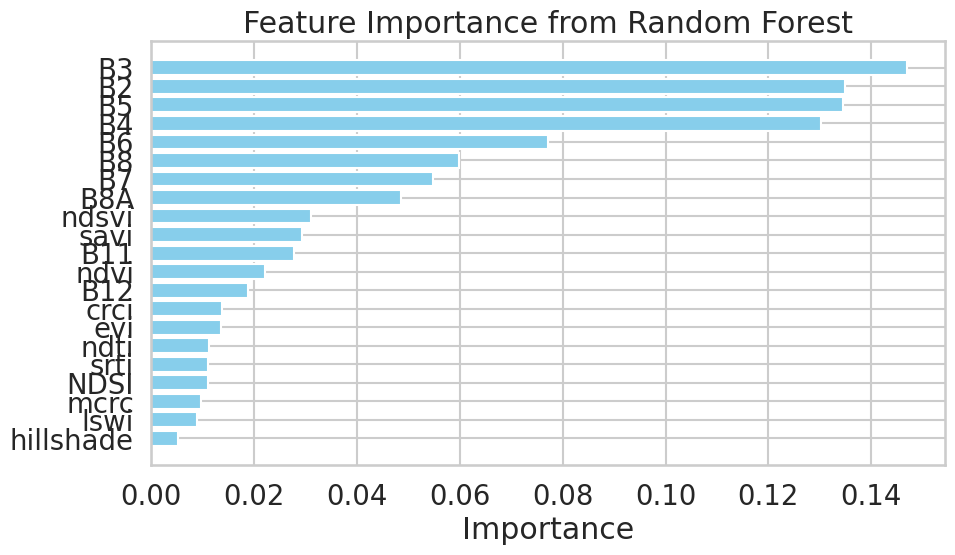

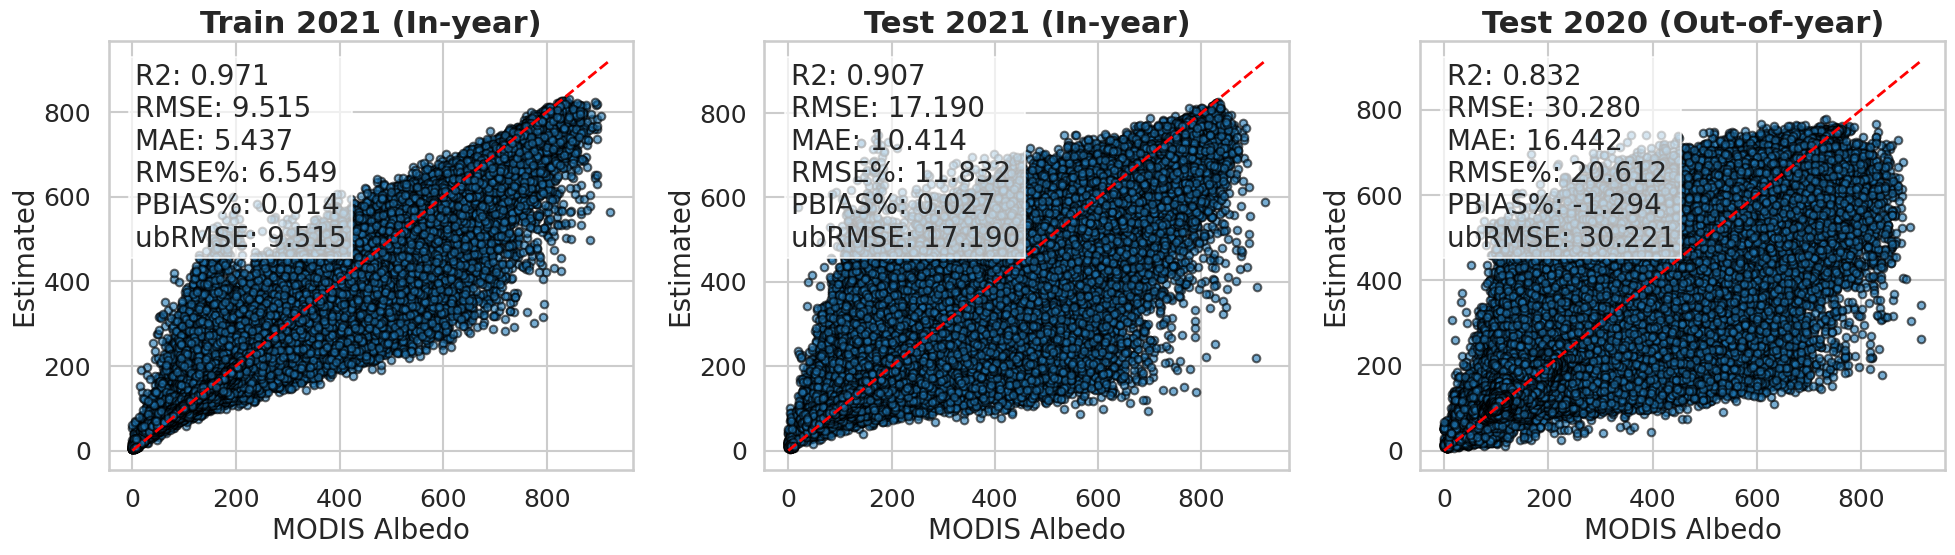

✅ Publication-ready predicted vs actual plots saved to /home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results/predicted_vs_actual.png


In [10]:
# -------------------------
# Plot Feature Importance
plot_feature_importance(feature_importances_df)
# -------------------------
#Plot Predicted vs Actual with metrics from metrics_df
# plot_predicted_vs_actual(
#     y_train=y_train,
#     y_train_pred=y_train_pred,
#     y_test=y_test,
#     y_test_pred=y_test_pred,
#     metrics_df=metrics_df,
#     output_dir=output_dir
# )

plot_predicted_vs_actual(
    y_train=y_train,
    y_train_pred=y_train_pred,
    y_test=y_test,
    y_test_pred=y_test_pred,
    y_test_2020=y_test_2020,
    y_test_2020_pred=y_test_2020_pred,
    metrics_df=metrics_df,
    output_dir=output_dir
)


In [ ]:
# save the model
import joblib
model_file = "random_forest_model.pkl"
joblib.dump(model, model_file)
print(f"✅ Trained RandomForest model saved to {model_file}")

##if you want to load saved model

# import joblib
# # Load the trained Random Forest model
# model = joblib.load('random_forest_model.pkl')


✅ Trained RandomForest model saved to random_forest_model.pkl


# Predict high resolution albedo using trained model

In [34]:
import rasterio
import numpy as np
import os

# -------------------------------------------------
# 1. Load Mosaic TIFF
# -------------------------------------------------
tif_path = r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/S2_HS/S2_500m_2021-09-16_20210916T185021_20210916T185515_T10TGQ_2021_09_16.tif"  # input mosaic

with rasterio.open(tif_path) as src:
    data = src.read()       # (bands, rows, cols)
    profile = src.profile
    rows, cols = src.height, src.width

print("Input shape:", data.shape)

# -------------------------------------------------
# 2. Prepare data for prediction
# -------------------------------------------------
bands, rows, cols = data.shape
flat_data = data.reshape(bands, rows * cols).T

mask_nan = np.any(np.isnan(flat_data), axis=1)
flat_data_clean = np.nan_to_num(flat_data)

# -------------------------------------------------
# 3. Predict using trained RF model
# -------------------------------------------------
print("Predicting...")
y_pred_flat = model.predict(flat_data_clean)
y_pred_flat[mask_nan] = 0  # assign 0 to NaN pixels

y_pred = y_pred_flat.reshape(rows, cols)

# -------------------------------------------------
# 4. Save prediction using SAME base name + different extension
# -------------------------------------------------
dir_name = os.path.dirname(tif_path)
base_name = os.path.splitext(os.path.basename(tif_path))[0]

# Set the new extension here (e.g., .tiff)
new_ext = ".tiff"
output_tif = os.path.join(dir_name, f"Pred_{base_name}{new_ext}")

print("Saving prediction as:", output_tif)

profile.update({
    "count": 1,
    "dtype": "int16"
})

with rasterio.open(output_tif, "w", **profile) as dst:
    dst.write(y_pred.astype("int16"), 1)

print("DONE — prediction saved at:", output_tif)


Input shape: (21, 229, 321)
Predicting...


/home/varunt/anaconda3/envs/myenv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Saving prediction as: /home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/S2_HS/Pred_S2_500m_2021-09-16_20210916T185021_20210916T185515_T10TGQ_2021_09_16.tiff
DONE — prediction saved at: /home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/S2_HS/Pred_S2_500m_2021-09-16_20210916T185021_20210916T185515_T10TGQ_2021_09_16.tiff


# Plot accuracy per land cover

In [11]:
#Compute metrics per land cover for train
metrics_df_by_LC_train = train.groupby('landcover').apply(compute_metrics).reset_index()
metrics_df_by_LC_train = metrics_df_by_LC_train.sort_values('RMSE_percent')

# # # Get labels and colors
land_cover_info = get_land_cover_labels_and_colors()

# #Step 3: Plot and save
plot_and_save_land_cover_metrics(metrics_df_by_LC_train, land_cover_info, output_dir=output_dir, dataset_name="train")

#Test
#Compute metrics per land cover for test
metrics_df_by_LC_test = test.groupby('landcover').apply(compute_metrics).reset_index()
metrics_df_by_LC_test = metrics_df_by_LC_test.sort_values('RMSE_percent')

# Get labels and colors
plot_and_save_land_cover_metrics(metrics_df_by_LC_test, land_cover_info, output_dir=output_dir, dataset_name="test")

/tmp/ipykernel_97485/3698632824.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_by_LC_train = train.groupby('landcover').apply(compute_metrics).reset_index()
/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/visualization.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/visualization.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

✅ Plots and CSV for 'train' saved to '/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results/'


/tmp/ipykernel_97485/3698632824.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics_df_by_LC_test = test.groupby('landcover').apply(compute_metrics).reset_index()
/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/visualization.py:219: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/visualization.py:235: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `

✅ Plots and CSV for 'test' saved to '/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results/'


In [12]:
# SCATTER PLOT FOR TRAIN AND TEST
# For train
train_metrics_lc = train.groupby('landcover').apply(
    lambda x: regression_metrics(x['MODIS_Albedo_WSA_shortwave'], x['RF_Predicted'])
)
train_metrics_lc = pd.DataFrame(train_metrics_lc.tolist(), index=train_metrics_lc.index)

# For test
test_metrics_lc = test.groupby('landcover').apply(
    lambda x: regression_metrics(x['MODIS_Albedo_WSA_shortwave'], x['RF_Predicted'])
)
test_metrics_lc = pd.DataFrame(test_metrics_lc.tolist(), index=test_metrics_lc.index)

plot_scatter_per_land_cover_with_metrics(train, train_metrics_lc,n_cols=3,title_fontsize=18,label_fontsize=18,tick_fontsize=18,metrics_fontsize=18 ,output_dir=output_dir, dataset_name="train")
plot_scatter_per_land_cover_with_metrics(test, test_metrics_lc,n_cols=3,title_fontsize=18,label_fontsize=18,tick_fontsize=18,metrics_fontsize=18 ,output_dir=output_dir, dataset_name="test")


/tmp/ipykernel_97485/1177113176.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_metrics_lc = train.groupby('landcover').apply(
/tmp/ipykernel_97485/1177113176.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_metrics_lc = test.groupby('landcover').apply(


✅ Publication-ready scatter plot figure saved as '/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results/scatter_train_all_landcovers.png'
✅ Publication-ready scatter plot figure saved as '/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/RF_results/split_test_results/scatter_test_all_landcovers.png'


In [ ]:
# DENSITY PLOT FOR TRAIN AND TEST
# Train density scatter plots
# plot_density_scatter_per_land_cover(train, train_metrics_lc, output_dir="Output/scatter_density_per_land_cover", dataset_name="train")
# plot_density_scatter_per_land_cover(test, test_metrics_lc, output_dir="Output/scatter_density_per_land_cover", dataset_name="test")

⚠️ KDE failed for land cover 0.0 (Class 0.0). Using scatter plot instead.
⚠️ KDE failed for land cover 1.0 (Evergreen Needleleaf Forests). Using scatter plot instead.
⚠️ KDE failed for land cover 2.0 (Evergreen Broadleaf Forests). Using scatter plot instead.
⚠️ KDE failed for land cover 5.0 (Mixed Forests). Using scatter plot instead.
⚠️ KDE failed for land cover 8.0 (Woody Savannas). Using scatter plot instead.
⚠️ KDE failed for land cover 9.0 (Savannas). Using scatter plot instead.
⚠️ KDE failed for land cover 10.0 (Grasslands). Using scatter plot instead.
⚠️ KDE failed for land cover 11.0 (Permanent Wetlands). Using scatter plot instead.
⚠️ KDE failed for land cover 12.0 (Croplands). Using scatter plot instead.
⚠️ KDE failed for land cover 13.0 (Urban and Built-up Lands). Using scatter plot instead.
⚠️ KDE failed for land cover 14.0 (Cropland/Natural Veg. Mosaics). Using scatter plot instead.
⚠️ KDE failed for land cover 17.0 (Water Bodies). Using scatter plot instead.
✅ Density sca

# Neural Network

In [77]:
import importlib
import ANN

importlib.reload(ANN)

#from ANN import train_model, evaluate_model, regression_metrics, RegressionNet, plot_history
from ANN import train_model, RegressionNet, plot_history
import torch
import numpy as np


from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:

import torch
import numpy as np
import pandas as pd

# 🔹 Define Z-score normalization function
def z_score_normalize(train, val, test):
    """
    Apply Z-score normalization using training data statistics.

    Parameters:
        train, val, test : np.ndarray
            Arrays to normalize.

    Returns:
        train_norm, val_norm, test_norm, mean, std : np.ndarray
    """
    mean = np.mean(train, axis=0)
    std = np.std(train, axis=0)
    std[std == 0] = 1e-8  # avoid division by zero

    train_norm = (train - mean) / std
    val_norm = (val - mean) / std
    test_norm = (test - mean) / std

    return train_norm, val_norm, test_norm, mean, std


# 🔹 Read validation data
validation = pd.read_csv(
    r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/Splited_data/splitted_without_water/fulldata/validation.csv"
)
validation = validation.dropna()



# 🔹 Select features and target
X_val = validation[train_columns]
y_val = validation[test_column]

# 🔹 Convert to numpy arrays
X_train_np = np.array(X_train)
X_val_np   = np.array(X_val)
X_test_np  = np.array(X_test)
X_test_np_2020=np.array(X_test_2020)

y_train_np = np.array(y_train).reshape(-1, 1)
y_val_np   = np.array(y_val).reshape(-1, 1)
y_test_np  = np.array(y_test).reshape(-1, 1)
y_test_np_2020  = np.array(y_test_2020).reshape(-1, 1)

# 🔹 Apply Z-score normalization
X_train_scaled, X_val_scaled, X_test_scaled, X_mean, X_std = z_score_normalize(X_train_np, X_val_np, X_test_np)
y_train_scaled, y_val_scaled, y_test_scaled, y_mean, y_std = z_score_normalize(y_train_np, y_val_np, y_test_np)

# 🔹 Convert to tensors
X_train_tensor = torch.as_tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.as_tensor(y_train_scaled, dtype=torch.float32)
X_val_tensor   = torch.as_tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor   = torch.as_tensor(y_val_scaled, dtype=torch.float32)
X_test_tensor  = torch.as_tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor  = torch.as_tensor(y_test_scaled, dtype=torch.float32)


# Normalize 2020 using training stats
X_test_scaled_2020 = (X_test_np_2020 - X_mean) / X_std
y_test_scaled_2020 = (y_test_np_2020 - y_mean) / y_std

# Convert to tensors
X_test_tensor_2020 = torch.as_tensor(X_test_scaled_2020, dtype=torch.float32)
y_test_tensor_2020 = torch.as_tensor(y_test_scaled_2020, dtype=torch.float32)



In [ ]:
# -----------------------------
# Ensure y tensors have correct shape
# -----------------------------
if y_train_tensor.ndim == 1:
    y_train_tensor = y_train_tensor.unsqueeze(1)
if y_val_tensor.ndim == 1:
    y_val_tensor = y_val_tensor.unsqueeze(1)
if y_test_tensor.ndim == 1:
    y_test_tensor = y_test_tensor.unsqueeze(1)

# -----------------------------
# Define input/output dimensions
# -----------------------------
input_dim = X_train_tensor.shape[1]
output_dim = y_train_tensor.shape[1]  # usually 1 for regression


# Specify a log directory for tensor board
log_dir = "runs/NN_experiment"

# Launch TensorBoard in Jupyter
%tensorboard --logdir {log_dir}

model, history = train_model(
    X_train=X_train_tensor,
    y_train=y_train_tensor,
    X_val=X_val_tensor,
    y_val=y_val_tensor,
    input_dim=input_dim,
    output_dim=output_dim,
    batch_size=32,
    epochs=200,  # adjust as needed
    lr=0.0001,
    hidden_dims=[128, 64, 32],
    log_dir=log_dir  # use same log dir for TensorBoard
)


Reusing TensorBoard on port 6006 (pid 53076), started 4:33:54 ago. (Use '!kill 53076' to kill it.)

Epoch 1/200 | Train Loss: 0.1374, R2: 0.8626, MSE: 0.1374 | Val Loss: 0.1441, R2: 0.8556, MSE: 0.1441
Epoch 2/200 | Train Loss: 0.1284, R2: 0.8716, MSE: 0.1284 | Val Loss: 0.1609, R2: 0.8389, MSE: 0.1609
Epoch 3/200 | Train Loss: 0.1274, R2: 0.8726, MSE: 0.1274 | Val Loss: 0.1378, R2: 0.8620, MSE: 0.1378
Epoch 4/200 | Train Loss: 0.1272, R2: 0.8728, MSE: 0.1272 | Val Loss: 0.1448, R2: 0.8550, MSE: 0.1448
Epoch 5/200 | Train Loss: 0.1268, R2: 0.8732, MSE: 0.1268 | Val Loss: 0.1500, R2: 0.8498, MSE: 0.1500
Epoch 6/200 | Train Loss: 0.1267, R2: 0.8733, MSE: 0.1267 | Val Loss: 0.1612, R2: 0.8386, MSE: 0.1612
Epoch 7/200 | Train Loss: 0.1265, R2: 0.8735, MSE: 0.1265 | Val Loss: 0.1382, R2: 0.8616, MSE: 0.1382
Epoch 8/200 | Train Loss: 0.1264, R2: 0.8736, MSE: 0.1264 | Val Loss: 0.1364, R2: 0.8634, MSE: 0.1364
Epoch 9/200 | Train Loss: 0.1264, R2: 0.8736, MSE: 0.1264 | Val Loss: 0.1316, R2: 0.8682, MSE: 0.1316
Epoch 10/200 | Train Loss: 0.1264, R2: 0.8736, MSE: 0.1264 | Val Loss: 0.1848, R2:

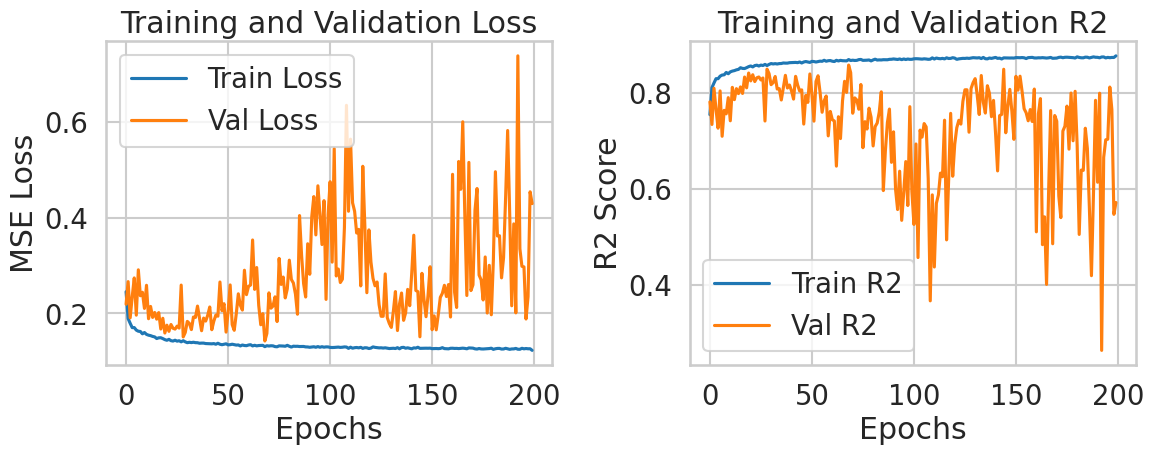

In [ ]:
plot_history(history)

In [ ]:
import torch
import torch.nn as nn
def evaluate_model(model, X, y):
    """
    Evaluate PyTorch model on given data.

    Args:
        model: trained PyTorch model
        X: input tensor
        y: target tensor

    Returns:
        loss: MSE loss (float)
        preds: predicted tensor
        targets: true tensor
    """
    model.eval()
    criterion = nn.MSELoss()

    with torch.no_grad():
        outputs = model(X)
        loss = criterion(outputs, y)

    return loss.item(), outputs, y


# Make sure model & tensors are on the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

X_test_tensor_2020 = X_test_tensor_2020.to(device)
y_test_tensor_2020 = y_test_tensor_2020.to(device)

# Evaluate training set
train_loss, y_train_pred, y_train_targets = evaluate_model(model, X_train_tensor, y_train_tensor)

# Evaluate test set
test_loss, y_test_pred, y_test_targets = evaluate_model(model, X_test_tensor, y_test_tensor)

# Evaluate 2020 set
test_loss_2020, y_test_2020_pred, y_test_2020_targets = evaluate_model(model, X_test_tensor_2020, y_test_tensor_2020)


Train Metrics: {'R2': 0.7667004289532209, 'RMSE': np.float64(27.264830174803592), 'MAE': 12.228409097786157, 'RMSE%': np.float64(18.759398183931157), 'PBIAS%': np.float64(-1.0318808408035285), 'ubRMSE': np.float64(27.223551763263263)}
Test Metrics: {'R2': 0.7077698829337538, 'RMSE': np.float64(30.239496589708338), 'MAE': 12.330264906824164, 'RMSE%': np.float64(20.8210015815243), 'PBIAS%': np.float64(-1.0346398534056958), 'ubRMSE': np.float64(30.202138205576436)}
Test 2020 Metrics: {'R2': 0.800708890484886, 'RMSE': np.float64(32.986273499879154), 'MAE': 17.071029347089592, 'RMSE%': np.float64(22.45344050632201), 'PBIAS%': np.float64(-2.1818144038054026), 'ubRMSE': np.float64(32.830173863854185)}


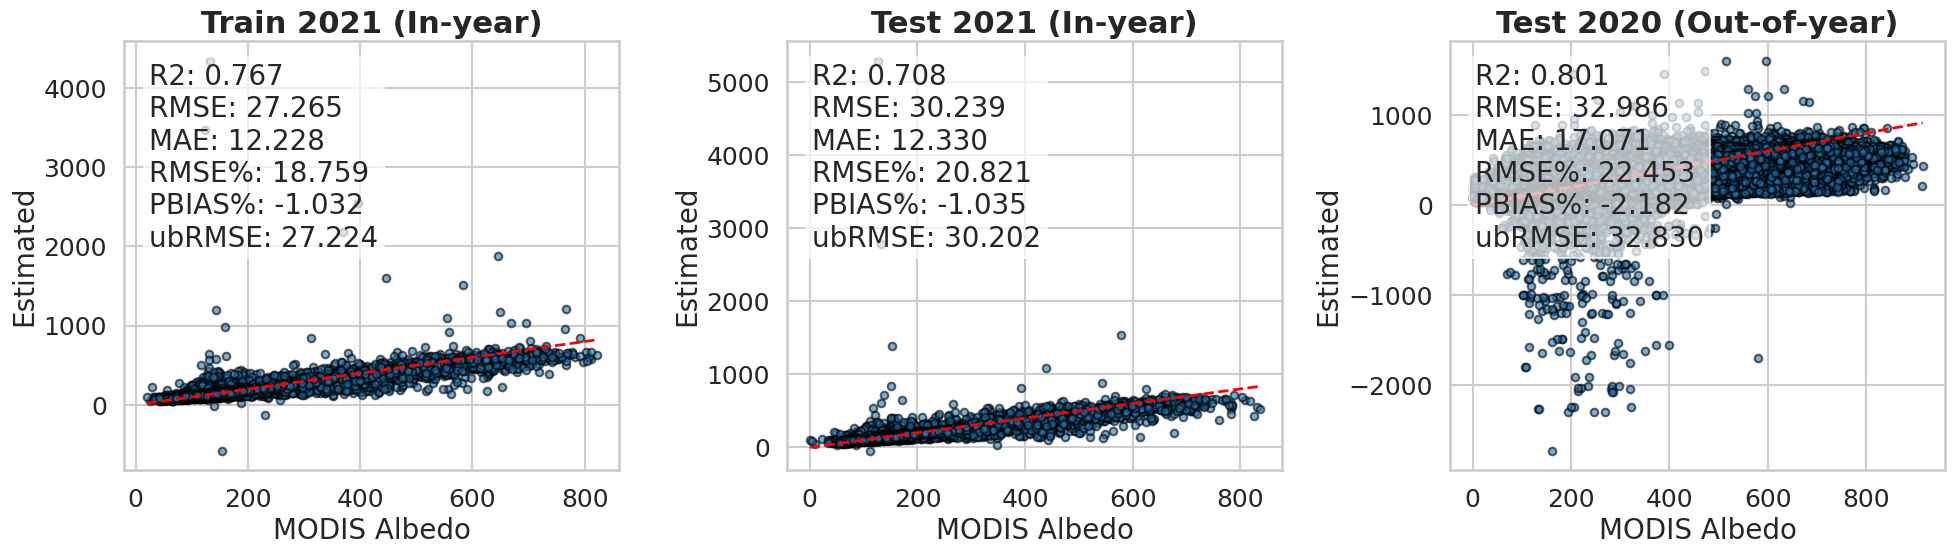

✅ Publication-ready predicted vs actual plots saved to /home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/NN_Results/predicted_vs_actual.png


In [ ]:

import numpy as np
import torch

# -----------------------------
# Function: Inverse Z-score normalization
# -----------------------------
def inverse_z_score(normalized, mean, std):
    """
    Reverse Z-score normalization to get back original values.

    Parameters:
        normalized : np.ndarray
            Normalized array to invert.
        mean : float or np.ndarray
            Mean used during normalization.
        std : float or np.ndarray
            Standard deviation used during normalization.

    Returns:
        np.ndarray : Original scale values
    """
    return normalized * std + mean




y_train_actual      = inverse_z(y_train_targets.cpu().numpy(), y_mean, y_std)
y_train_pred_actual = inverse_z(y_train_pred.cpu().numpy(), y_mean, y_std)

y_test_actual       = inverse_z(y_test_targets.cpu().numpy(), y_mean, y_std)
y_test_pred_actual  = inverse_z(y_test_pred.cpu().numpy(), y_mean, y_std)

y_test_2020_actual      = inverse_z(y_test_2020_targets.cpu().numpy(), y_mean, y_std)
y_test_2020_pred_actual = inverse_z(y_test_2020_pred.cpu().numpy(), y_mean, y_std)


metrics_train = regression_metrics(y_train_actual, y_train_pred_actual)
metrics_test = regression_metrics(y_test_actual, y_test_pred_actual)
metrics_test_2020 = regression_metrics(y_test_2020_actual, y_test_2020_pred_actual)

print("Train Metrics:", metrics_train)
print("Test Metrics:", metrics_test)
print("Test 2020 Metrics:", metrics_test_2020)


# 3. Build metrics_df for plotting
# -----------------------------
import pandas as pd



metrics_df = pd.DataFrame({
    "R2":      [metrics_train["R2"], metrics_test["R2"], metrics_test_2020["R2"]],
    "RMSE":    [metrics_train["RMSE"], metrics_test["RMSE"], metrics_test_2020["RMSE"]],
    "MAE":     [metrics_train["MAE"], metrics_test["MAE"], metrics_test_2020["MAE"]],
    "RMSE%":   [metrics_train["RMSE%"], metrics_test["RMSE%"], metrics_test_2020["RMSE%"]],
    "PBIAS%":  [metrics_train["PBIAS%"], metrics_test["PBIAS%"], metrics_test_2020["PBIAS%"]],
    "ubRMSE":  [metrics_train["ubRMSE"], metrics_test["ubRMSE"], metrics_test_2020["ubRMSE"]]
}, index=["Train", "Test_All", "Test_2020"])



output_dir=r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/NN_Results/"
# Then plot
plot_predicted_vs_actual(
    y_train=y_train_actual,
    y_train_pred=y_train_pred_actual,
    y_test=y_test_actual,
    y_test_pred=y_test_pred_actual,
    y_test_2020=y_test_2020_actual,
    y_test_2020_pred=y_test_2020_pred_actual,
    metrics_df=metrics_df,
    output_dir=output_dir
)


In [ ]:
# from sklearn.preprocessing import MinMaxScaler

# ## -----------------------------
# # Train set predictions
# # -----------------------------
# train_loss, train_preds_scaled, train_targets_scaled = evaluate_model(model, X_train_tensor, y_train_tensor)

# # Inverse scale
# train_preds = y_scaler.inverse_transform(train_preds_scaled.reshape(-1, 1)).flatten()
# train_targets = y_scaler.inverse_transform(train_targets_scaled.reshape(-1, 1)).flatten()

# # Add predictions to train DataFrame
# train['NN_Predicted'] = train_preds

# # Compute regression metrics
# train_metrics_df = regression_metrics(train_targets, train_preds)
# print("Train set metrics:", train_metrics_df)

# # # Save train DataFrame with predictions
# # train.to_csv("Output/train_predictions_with_NN.csv", index=False)
# # print("✅ Train predictions (original scale) saved to 'Output/train_predictions_with_NN.csv'")

# # -----------------------------
# # Test set predictions
# # -----------------------------
# test_loss, test_preds_scaled, test_targets_scaled = evaluate_model(model, X_test_tensor, y_test_tensor)

# # Inverse scale
# test_preds = y_scaler.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
# test_targets = y_scaler.inverse_transform(test_targets_scaled.reshape(-1, 1)).flatten()

# # Add predictions to test DataFrame
# test['NN_Predicted'] = test_preds

# # Compute regression metrics
# test_metrics_df = regression_metrics(test_targets, test_preds)
# print("Test set metrics:", test_metrics_df)

# # # Save test DataFrame with predictions
# # test.to_csv("Output/test_predictions_with_NN.csv", index=False)
# # print("✅ Test predictions (original scale) saved to 'Output/test_predictions_with_NN.csv'")

# -----------------------------
# Define inverse Z-score function
# -----------------------------


import numpy as np
import torch

# -----------------------------
# Function: Inverse Z-score normalization
# -----------------------------
def inverse_z_score(normalized, mean, std):
    """
    Reverse Z-score normalization to get back original values.

    Parameters:
        normalized : np.ndarray
            Normalized array to invert.
        mean : float or np.ndarray
            Mean used during normalization.
        std : float or np.ndarray
            Standard deviation used during normalization.

    Returns:
        np.ndarray : Original scale values
    """
    return normalized * std + mean


# -----------------------------
# Ensure everything is on same device
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# -----------------------------
# Train set predictions
# -----------------------------
train_loss, train_preds_scaled, train_targets_scaled = evaluate_model(model, X_train_tensor, y_train_tensor)

# Convert tensors (from GPU) to NumPy arrays
train_preds_scaled = np.array(train_preds_scaled).reshape(-1, 1)
train_targets_scaled = np.array(train_targets_scaled).reshape(-1, 1)

# 🔹 Inverse Z-score normalization
train_preds = inverse_z_score(train_preds_scaled, y_mean, y_std).flatten()
train_targets = inverse_z_score(train_targets_scaled, y_mean, y_std).flatten()

# Add predictions to train DataFrame
train['NN_Predicted'] = train_preds

# Compute regression metrics
train_metrics_df = regression_metrics(train_targets, train_preds)
print("\n✅ Train set metrics:", train_metrics_df)


# -----------------------------
# Test set predictions
# -----------------------------
test_loss, test_preds_scaled, test_targets_scaled = evaluate_model(model, X_test_tensor, y_test_tensor)

# Convert tensors (from GPU) to NumPy arrays
test_preds_scaled = np.array(test_preds_scaled).reshape(-1, 1)
test_targets_scaled = np.array(test_targets_scaled).reshape(-1, 1)

# 🔹 Inverse Z-score normalization
test_preds = inverse_z_score(test_preds_scaled, y_mean, y_std).flatten()
test_targets = inverse_z_score(test_targets_scaled, y_mean, y_std).flatten()

# Add predictions to test DataFrame
test['NN_Predicted'] = test_preds

# Compute regression metrics
test_metrics_df = regression_metrics(test_targets, test_preds)
print("\n✅ Test set metrics:", test_metrics_df)

TypeError: regression_metrics() takes 2 positional arguments but 3 were given

In [82]:
def plot_scatter_per_land_cover_with_metrics_NN(data, metrics_df_per_lc, 
                                             output_dir="NN_Results/scatter_per_land_cover", 
                                             dataset_name="test"):
    """
    Creates scatter plots of observed vs predicted albedo for each land cover type,
    including regression metrics per land cover.

    Parameters:
    - data (pd.DataFrame): Must contain 'landcover', 'MODIS_Albedo_WSA_shortwave' (observed),
                           and 'NN_Predicted' (predicted by the neural network)
    - metrics_df_per_lc (pd.DataFrame): Metrics per landcover type (index=landcover)
    - output_dir (str): Directory to save plots
    - dataset_name (str): 'train' or 'test' for file naming
    """
    import os
    import matplotlib.pyplot as plt

    land_cover_labels, land_cover_colors = get_land_cover_labels_and_colors()
    os.makedirs(output_dir, exist_ok=True)

    for lc in sorted(data['landcover'].unique()):
        subset = data[data['landcover'] == lc]
        if subset.empty:
            continue

        lc_name = land_cover_labels.get(lc, f"Class {lc}")
        lc_color = land_cover_colors.get(lc, "#333333")

        x = subset['MODIS_Albedo_WSA_shortwave']  # observed
        y = subset['NN_Predicted']                # predicted

        # Compute axis limits with padding
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        range_padding = (max_val - min_val) * 0.05
        xlim = (min_val - range_padding, max_val + range_padding)
        ylim = (min_val - range_padding, max_val + range_padding)

        plt.figure(figsize=(7, 6))
        plt.scatter(x, y, s=10, color=lc_color, alpha=0.6)
        plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray', linewidth=1)  # 1:1 line

        # Add metrics if available
        if lc in metrics_df_per_lc.index:
            lc_metrics = metrics_df_per_lc.loc[lc]
            metrics_text = "\n".join([f"{k}: {v:.3f}" for k, v in lc_metrics.items()])
            plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
                     verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

        plt.title(f"Scatter Plot - {lc_name} ({dataset_name})")
        plt.xlabel("Observed Albedo")
        plt.ylabel("Predicted Albedo (NN_Predicted)")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.tight_layout()

        filename = os.path.join(
            output_dir,
            f"scatter_{dataset_name}_lc{lc}_{lc_name.replace(' ', '_').replace('/', '').replace('.', '')}.png"
        )
        plt.savefig(filename, dpi=300)
        plt.close()

    print(f"✅ Scatter plots with metrics for '{dataset_name}' saved to '{output_dir}'")


In [83]:
# -----------------------------
# Train set scatter plots
# -----------------------------
# Compute metrics per land cover for train
train_metrics_per_lc = train.groupby('landcover').apply(
    lambda df: regression_metrics(df['MODIS_Albedo_WSA_shortwave'], df['NN_Predicted'])
)
train_metrics_per_lc.index.name = 'landcover'

# Plot and save
plot_scatter_per_land_cover_with_metrics_NN(
    data=train,
    metrics_df_per_lc=train_metrics_per_lc,
    output_dir="Results_NN/scatter_per_land_cover",
    dataset_name="train"
)

# -----------------------------
# Test set scatter plots
# -----------------------------
# Compute metrics per land cover for test
test_metrics_per_lc = test.groupby('landcover').apply(
    lambda df: regression_metrics(df['MODIS_Albedo_WSA_shortwave'], df['NN_Predicted'])
)
test_metrics_per_lc.index.name = 'landcover'

# Plot and save
plot_scatter_per_land_cover_with_metrics_NN(
    data=test,
    metrics_df_per_lc=test_metrics_per_lc,
    output_dir="Results_NN/scatter_per_land_cover",
    dataset_name="test"
)

/tmp/ipykernel_798601/1039354486.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_metrics_per_lc = train.groupby('landcover').apply(


✅ Scatter plots with metrics for 'train' saved to 'Results_NN/scatter_per_land_cover'


/tmp/ipykernel_798601/1039354486.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_metrics_per_lc = test.groupby('landcover').apply(


✅ Scatter plots with metrics for 'test' saved to 'Results_NN/scatter_per_land_cover'


In [28]:
import os
from osgeo import gdal

# -----------------------------
# 1. Input folder and output
# -----------------------------
input_folder = r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/S2_HS/2021-09-16/"
output_tif = r"/home/varunt/Downloads/albedo-mapping-dev/2_Random Forest/New_revisions/output/S2_HS/2021-09-16/mosaic_2021_09_16.tif"

# -----------------------------
# 2. Collect all TIFF files
# -----------------------------
tif_files = [
    os.path.join(input_folder, f)
    for f in os.listdir(input_folder)
    if f.lower().endswith((".tif", ".tiff"))
]

tif_files = sorted(tif_files)

print("Found TIFF files:")
for f in tif_files:
    print(f)

# -----------------------------
# 3. Mosaic using GDAL Warp (correct options)
# -----------------------------
warp_options = gdal.WarpOptions(
    format='GTiff',
    resampleAlg='near',
    multithread=True,
    creationOptions=[
        "COMPRESS=LZW",
        "TILED=YES",
        "BIGTIFF=YES"
    ]
)

# Remove old output if exists
if os.path.exists(output_tif):
    os.remove(output_tif)

gdal.Warp(
    destNameOrDestDS=output_tif,
    srcDSOrSrcDSTab=tif_files,
    options=warp_options
)

print("Mosaic created successfully:", output_tif)


ModuleNotFoundError: No module named 'osgeo'